# Import libraries and data

Dataset was obtained in the capstone project description (direct link [here](https://d3c33hcgiwev3.cloudfront.net/_429455574e396743d399f3093a3cc23b_capstone.zip?Expires=1530403200&Signature=FECzbTVo6TH7aRh7dXXmrASucl~Cy5mlO94P7o0UXygd13S~Afi38FqCD7g9BOLsNExNB0go0aGkYPtodekxCGblpc3I~R8TCtWRrys~2gciwuJLGiRp4CfNtfp08sFvY9NENaRb6WE2H4jFsAo2Z2IbXV~llOJelI3k-9Waj~M_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A)) and splited manually in separated csv files. They were stored at my personal github account (folder link [here](https://github.com/caiomiyashiro/RecommenderSystemsNotebooks/tree/master/data/capstone)) and you can download and paste inside your working directory in order for this notebook to run.

In [1]:
import pandas as pd
import numpy as np

## Preprocess data

Float data came with ',' in the csv and python works with '.', so it treated the number as text. In order to convert them to numbers, I first replaced all the commas by punct and then converted the columns to float.

In [2]:
items = pd.read_csv('data/capstone/Capstone Data - Office Products - Items.csv', index_col=0) 
actual_ratings = pd.read_csv('data/capstone/Capstone Data - Office Products - Ratings.csv', index_col=0) 

content_based = pd.read_csv('data/capstone/Capstone Data - Office Products - CBF.csv', index_col=0)
user_user = pd.read_csv('data/capstone/Capstone Data - Office Products - User-User.csv', index_col=0)
item_item = pd.read_csv('data/capstone/Capstone Data - Office Products - Item-Item.csv', index_col=0)
matrix_fact = pd.read_csv('data/capstone/Capstone Data - Office Products - MF.csv', index_col=0)
pers_bias = pd.read_csv('data/capstone/Capstone Data - Office Products - PersBias.csv', index_col=0)

items[['Availability','Price']] = items[['Availability','Price']].apply(lambda col: col.apply(lambda elem: str(elem).replace(',', '.'))).astype(float)

# preprocess
content_based = content_based.apply(lambda col: col.apply(lambda elem: str(elem).replace(',', '.'))).astype(float)
user_user = user_user.apply(lambda col: col.apply(lambda elem: str(elem).replace(',', '.'))).astype(float)
item_item = item_item.apply(lambda col: col.apply(lambda elem: str(elem).replace(',', '.'))).astype(float)
matrix_fact = matrix_fact.apply(lambda col: col.apply(lambda elem: str(elem).replace(',', '.'))).astype(float)
pers_bias = pers_bias.apply(lambda col: col.apply(lambda elem: str(elem).replace(',', '.'))).astype(float)

print('items.shape = ' + str(items.shape))
print('actual_ratings.shape = ' + str(actual_ratings.shape))
print('content_based.shape = ' + str(content_based.shape))
print('user_user.shape = ' + str(user_user.shape))
print('item_item.shape = ' + str(item_item.shape))
print('matrix_fact.shape = ' + str(matrix_fact.shape))
print('pers_bias.shape = ' + str(pers_bias.shape))

actual_ratings.head()

items.shape = (200, 7)
actual_ratings.shape = (200, 100)
content_based.shape = (200, 100)
user_user.shape = (200, 100)
item_item.shape = (200, 100)
matrix_fact.shape = (200, 100)
pers_bias.shape = (200, 100)


,64,65,75,79,83,112,252,271,301,305,...,3411,3430,3524,3533,3625,3902,3991,4047,4342,4462
item,,,,,,,,,,,,,,,,,,,,,
24,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,NaN,5.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Class RecommenderEvaluator

In order to become easier to evaluate the metrics, I created a class that receives all the original ratings and predicted ratings for every recommender system and defined functions to extract all the metrics established in section 1 of the capstone report. Lets take a look at a summary of the class before looking at the code:
- **Constructor (init)**: receive all recommendation algorithms, besides the actual rating list and the list of items. All data is contained in the data downloaded from Coursera. Besides storing all recommendation algorithms, the constructor also calculate the 20 most frequent items, which is used in the popularity metric calculation.

- **get_observed_ratings**: as the ratings matrix is sparse, this method only returns the items a user with id userId has purchased.

- **get_top_n**: by ordering all the predicted ratings for each recommendation algorithm, we can extract what would be their 'top' recommendation for a given user. Given a parameter $n$, we can then return all the top $n$ recommendations for all the recommendation algorithms.

- **rmse**: by comparing the observed ratings a given user has given to an item and the predicted rating an algorithm has defined for a user, we can have an idea of how much error the algorithm is predicting the user's ratings. Here we don't work with lists, as usually each user has rated only a few amount of items. So here we get all the items the user has rated, recover these items from the algorithms' recommendations and them calculate the error.

- **nDCG**: By looking at lists now, we can have an idea of how optimal the ranked lists are. By using the scoring factor defined in the report, we can calculate the overall DCG for the recommenders' lists and then normalise them using the concepts of the nDCG.

- **Price and avalaibility diversity**: Diversity metric which evaluate how the recommended items' prices vary, *i.e.*, how is the standard deviation of the price. The higher, the better in this case. The same is for the availability index, but here, with higher standard deviations, it means the models are recommending items which are present and not present in local stores.

- **Popularity**: A popular recommender tries to recommend items which has a high chance of being purchased. In the formulation of this metric, an item has a high chance of being purchased if lots of people have purchased them. In the class constructor, we take the observed ratings data and the item list and select which were the top $n$ (standard = 20) most purchased data. In a recommendation list, we return the ration of how many items were inside this list of top $n$ ones.

In [3]:
class RecommenderEvaluator:
    
    def __init__(self, items, actual_ratings, content_based, user_user, item_item, matrix_fact, pers_bias):
        
        self.items = items
        self.actual_ratings = actual_ratings
        # static data containing the average score given by each user
        self.average_rating_per_userid = actual_ratings.apply(lambda row: np.average(row[~np.isnan(row)]))
        
        self.content_based = content_based
        self.user_user = user_user
        self.item_item = item_item
        self.matrix_fact = matrix_fact
        self.pers_bias = pers_bias
        
        # aggregate list. Makes for loops among all recommenders' predictions easier
        self.recommenders_list = [self.content_based, self.user_user, self.item_item, self.matrix_fact,self.pers_bias]
        self.recommenders_list_names = ['content_based', 'user_user', 'item_item', 'matrix_fact','pers_bias']
        
        # Used for item popularity metric.
        # Calculate the 20 most popular items (item which most of the customers bought)
        N_LIM = 20
        perc_users_bought_item = self.actual_ratings.apply(lambda item: np.sum(~np.isnan(item)), axis=0)/actual_ratings.shape[1]
        sort_pop_items = np.argsort(perc_users_bought_item)[::-1]
        self.pop_items = perc_users_bought_item.iloc[sort_pop_items][:N_LIM].index.values.astype(np.int)
    
        
    def get_observed_ratings(self, userId):
        """
        Returns all the items a given user evaluated and their ratings. Used mainly by all the metrics calculation
        :parameter: userId - user id
        :return: array of rated items. Index is the item id and value is the item rating
        """
        userId = str(userId)
        filtered_ratings = self.actual_ratings[userId]
        rated_items = filtered_ratings[~np.isnan(filtered_ratings)]
        return rated_items
    
    def get_top_n(self, userId, n):
        """
        Get the top n recommendations for every recommender in the list given a user id
        :parameter: userId - user id
        :parameter: n - max number of recommendations to return
        :return: dictionary where the key is the recommender's name and the value is an array of size n for the top n recommnendations.
        """
        userId = str(userId)
        predicted_ratings = dict()
        for recommender, recommender_name in zip(self.recommenders_list,self.recommenders_list_names):
            item_ids = recommender[userId].argsort().sort_values()[:n].index.values
            predicted_ratings[recommender_name] = item_ids
        return predicted_ratings
    
    def rmse(self, userId):
        """
        Root Mean Square Error of the predicted and observed values between the recommender's prediction and the actual ratings
        :parameter: userId - user id
        :return: dataframe of containing the rmse from all recommenders given user id
        """
        userId = str(userId)
        observed_ratings = self.get_observed_ratings(userId)
        rmse_list = {'rmse': []}
        for recommender in self.recommenders_list:
            predicted_ratings = recommender.loc[observed_ratings.index, userId]
            rmse_list['rmse'].append(np.sqrt(np.average((predicted_ratings - observed_ratings)**2)))
        rmse_list = pd.DataFrame(rmse_list, index = self.recommenders_list_names)
        return rmse_list
    
    def nDCG(self, userId, top_n = 5, individual_recommendation = None):
        """
        Normalised Discounted Cumulative Gain for all recommenders given user id
        :parameter: userId - user id
        :return: dataframe of containing the nDCG from all recommenders given user id
        """
        ri = self.get_observed_ratings(userId)
        
        if(individual_recommendation is None):
            topn = self.get_top_n(userId,top_n)
            results_pandas_index = self.recommenders_list_names
        else:
            topn = individual_recommendation
            results_pandas_index = list(individual_recommendation.keys())

        # 1st step: Given recommendations, transform list into scores (see score transcriptions in the capstone report)
        scores_all = []
        for name, item_list in topn.items():
            scores = np.empty_like(item_list) # initialise 'random' array
            scores[:] = -10                   ###########################
                                                                   # check which items returned by the recommender
            is_already_rated = np.isin(item_list, ri.index.values) # the user already rated. Items users didn't rate
            scores[~is_already_rated] = 0                          # receive score = 0
            for index, score in enumerate(scores):
                if(score != 0):                                    # for each recommended items the user rated
                    if(ri[item_list[index]] < self.average_rating_per_userid[userId] - 1): # score accordingly the report 
                        scores[index] = -1
                    elif((ri[item_list[index]] >= self.average_rating_per_userid[userId] - 1) & 
                         (ri[item_list[index]] < self.average_rating_per_userid[userId] + 0.5)):
                        scores[index] = 1
                    else:
                        scores[index] = 2
            scores_all.append(scores)                              # append all the transformed scores
        scores_all  

        # 2nd step: Given scores, calculate the model's DCG, ideal DCG and then nDCG
        nDCG_all = dict()
        
        for index_model, scores_model in enumerate(scores_all):   # for each model
            model_DCG = 0                                         # calculate model's DCG
            for index, score in enumerate(scores_model):          #
                index_ = index + 1                                #
                model_DCG = model_DCG + score/np.log2(index_ + 1) #   
            ideal_rank_items = np.sort(scores_model)[::-1]                        # calculate model's ideal DCG
            ideal_rank_DCG = 0                                                    #
            for index, ideal_score in enumerate(ideal_rank_items):                #
                index_ = index + 1                                                #
                ideal_rank_DCG = ideal_rank_DCG + ideal_score/np.log2(index_ + 1) #
            if((ideal_rank_DCG == 0) | (np.abs(ideal_rank_DCG) < np.abs(model_DCG))): # if nDCG is 0 or only negative scores came up
                nDCG = 0 
            else:                                                     # calculate final nDCG when ideal DCG is != 0
                nDCG = model_DCG/ideal_rank_DCG
                                                         
            nDCG_all[results_pandas_index[index_model]] = nDCG # save each model's nDCG in a dict
            # convert it to dataframe
            result_final = pd.DataFrame(nDCG_all, index=range(1)).transpose()
            result_final.columns = ['nDCG']
        return result_final

    def price_diversity(self,userId,top_n = 5,individual_recommendation = None):
        """
        Mean and standard deviation of the price of the top n products recommended by each algorithm. 
        Intuition for a high price wise diversity recommender is to have a high price standard deviation
        :parameter: userId - user id
        :return: dataframe of containing the price's mean and standard deviation from all recommenders given user id
        """

        if(individual_recommendation is None):
            topn = self.get_top_n(userId,top_n)
        else:
            topn = individual_recommendation

        stats = pd.DataFrame()
        for key, value in topn.items():
            data_filtered = self.items.loc[topn[key]][['Price']].agg(['mean','std']).transpose()
            data_filtered.index = [key]
            stats = stats.append(data_filtered)
        return stats
    
    def availability_diversity(self,userId,top_n = 5,individual_recommendation = None):
        """
        Mean and standard deviation of the availabity index of the top n products recommended by each algorithm. 
        Intuition for a high availabity diversity is to have a small mean value in the availabity index
        :parameter: userId - user id
        :return: dataframe of containing the availabity index's mean and standard deviation from all recommenders given user id
        """
        if(individual_recommendation is None):
            topn = self.get_top_n(userId,top_n)
        else:
            topn = individual_recommendation

        stats = pd.DataFrame()
        for key, value in topn.items():
            data_filtered = self.items.loc[topn[key]][['Availability']].agg(['mean','std']).transpose()
            data_filtered.index = [key]
            stats = stats.append(data_filtered)
        return stats
    
    def popularity(self, userId,top_n = 5,individual_recommendation = None):
        """
        Return the ratio of how many items of the top n items are among the most popular purchased items. Default is
        the 20 most purchased items.
        :parameter: userId - user id
        :return: dataframe of containing ratio of popular items in the recommended list from all recommenders given user id
        """
        if(individual_recommendation is None):
            topn = self.get_top_n(userId,top_n)
            results_pandas_index = self.recommenders_list_names
        else:
            topn = individual_recommendation
            results_pandas_index = list(individual_recommendation.keys())

        results = {'popularity': []}
        for recommender, recommendations in topn.items():
            popularity = np.sum(np.isin(recommendations,self.pop_items))
            results['popularity'].append(popularity)
        return pd.DataFrame(results,index = results_pandas_index)
    
    def precision_at_n(self, userId, top_n = 5, individual_recommendation = None):
        
        if(individual_recommendation is None):
            topn = self.get_top_n(userId,top_n)
            results_pandas_index = self.recommenders_list_names
        else:
            topn = individual_recommendation
            results_pandas_index = list(individual_recommendation.keys())
        
        observed_ratings = self.get_observed_ratings(userId).index.values
        precisions = {'precision_at_'+str(top_n): []}
        for recommender, recommendations in topn.items():
            precisions['precision_at_'+str(top_n)].append(np.sum(np.isin(recommendations, observed_ratings))/top_n)
        return pd.DataFrame(precisions,index = results_pandas_index)
    

# Test methods:

Just to have an idea of the output of each method, lets call all them with a test user. At the next section we will calculate these metrics for all users.

In [4]:
userId = '64'
re = RecommenderEvaluator(items, actual_ratings, content_based, user_user, item_item, matrix_fact, pers_bias)

## Test RMSE

In [5]:
re.rmse(userId)

,rmse
content_based,0.772809
user_user,0.624086
item_item,0.797922
matrix_fact,0.853212
pers_bias,0.845591


## Test nDCG

In [6]:
re.nDCG(userId)

,nDCG
content_based,0.00000
item_item,0.63093
matrix_fact,0.00000
pers_bias,0.00000
user_user,0.00000


## Test Diversity - Price and Availability

In [7]:
re.price_diversity(userId)

,mean,std
content_based,10.376,5.160923
user_user,19.846,14.888584
item_item,6.518,3.736117
matrix_fact,9.706,5.622004
pers_bias,9.890,5.121875


In [8]:
re.availability_diversity(userId)

,mean,std
content_based,0.595712,0.197574
user_user,0.628495,0.124328
item_item,0.531987,0.228363
matrix_fact,0.588537,0.197005
pers_bias,0.588596,0.172630


## Test Popularity

In [9]:
re.popularity(userId)

,popularity
content_based,0
user_user,0
item_item,0
matrix_fact,0
pers_bias,0


## Test Precision@N

In [10]:
re.precision_at_n(userId)

,precision_at_5
content_based,0.0
user_user,0.0
item_item,0.2
matrix_fact,0.0
pers_bias,0.0


# Average metrics by all users

Espefically for user 907, the recommendations from the user user came with all nulls (original dataset). This specifically impacted the RMSE calculation, as one Nan damaged the entire average calculation. So specifically for RMSE we did a separate calculation section. All the other metrics are going the be calculated in the next code block.

In [11]:
re = RecommenderEvaluator(items, actual_ratings, content_based, user_user, item_item, matrix_fact, pers_bias)

i = 0
count = np.array([0,0,0,0,0])
for userId in actual_ratings.columns:
    if(userId == '907'):
        rmse_recommenders = re.rmse(userId).fillna(0)
    else:
        rmse_recommenders = re.rmse(userId)
    count = count + rmse_recommenders['rmse']

# as we didn't use user 907 for user user, divide it by the number of users - 1
denominator = [len(actual_ratings.columns)] * 5
denominator[1] = len(actual_ratings.columns) - 1
print('Average RMSE for all users')
count/ denominator

Average RMSE for all users


content_based    0.572387
user_user        0.545130
item_item        0.574672
matrix_fact      0.659029
pers_bias        0.666273
Name: rmse, dtype: float64

In [12]:
count_nDCG = np.array([0,0,0,0,0])
count_diversity_price = np.ndarray([5,2])
count_diversity_availability = np.ndarray([5,2])
count_popularity = np.array([0,0,0,0,0])
count_precision_at_5 = np.array([0,0,0,0,0])

for userId in actual_ratings.columns:
    nDCG_recommenders = re.nDCG(userId)
    count_nDCG = count_nDCG + nDCG_recommenders['nDCG']
    
    diversity_price_recommenders = re.price_diversity(userId)
    count_diversity_price = count_diversity_price + diversity_price_recommenders[['mean','std']]
    
    diversity_availability_recommenders = re.availability_diversity(userId)
    count_diversity_availability = count_diversity_availability + diversity_availability_recommenders[['mean','std']]
    
    popularity_recommenders = re.popularity(userId)
    count_popularity = count_popularity + popularity_recommenders['popularity'] 
    
    precision_recommenders = re.precision_at_n(userId)
    count_precision_at_5 = count_precision_at_5 + precision_recommenders['precision_at_5'] 

print('\n---')
print('Average nDCG')
print('---\n')
print(count_nDCG/len(actual_ratings.columns))
print('\n---')
print('Average Price - Diversity Measure')
print('---\n')
print(count_diversity_price/len(actual_ratings.columns))
print('\n---')
print('Average Availability - Diversity Measure')
print('---\n')
print(count_diversity_availability/len(actual_ratings.columns))
print('\n---')
print('Average Popularity')
print('---\n')
print(count_popularity/len(actual_ratings.columns))
print('---\n')
print('Average Precision@5')
print('---\n')
print(count_precision_at_5/len(actual_ratings.columns))


---
Average nDCG
---

content_based    0.136505
item_item        0.146798
matrix_fact      0.155888
pers_bias        0.125180
user_user        0.169080
Name: nDCG, dtype: float64

---
Average Price - Diversity Measure
---

                    mean        std
content_based  19.286627  19.229536
user_user      21.961776  25.275120
item_item      25.931943  32.224609
matrix_fact    21.165554  26.236822
pers_bias       9.938984   5.159261

---
Average Availability - Diversity Measure
---

                   mean       std
content_based  0.623888  0.225789
user_user      0.682751  0.230219
item_item      0.655725  0.223781
matrix_fact    0.601153  0.202596
pers_bias      0.638596  0.202630

---
Average Popularity
---

content_based    0.00
user_user        0.01
item_item        0.00
matrix_fact      0.00
pers_bias        0.00
Name: popularity, dtype: float64
---

Average Precision@5
---

content_based    0.050
user_user        0.066
item_item        0.076
matrix_fact      0.064
pers_bias  

# Final Analysis

In terms of **RMSE**, the user-user collaborative filtering showed to be the most effective, despite it not being significantly better.

For nDCG rank score, again user user and now item item collaborative filtering were the best.

In terms of price diversity, the item item algorith was the most diverse, providing products varying ~32 dollars from the mean item price list. Matrix factorisation and user user follow right behind, with price standard deviation around 25 dollars. An interesting factor here was the *pers_bias* algorithm, as it recommended basically cheap products with a low standard deviation.

For the availabity index, all the algorithms besides the user user managed to recommend items not so present in the local stores **together** with items present in local stores, as we can see they also provided items with availability index high (high standard deviation).

In terms of popularity, no algorithm actually managed to obtain good scores in the way we defined. So, if the popularity is focused in the future, we can either change the popularity concept or improve mechanics in the recommender so it predict higher scores for the most popular items in the store.

After this evaluation, it seemed to us that the item-item recommender system had an overall better performance, highlighted in terms of its diversity scores. Unfortunately, the items that item item recommender has suggested are in overall pricy, and we can check if there is any mixture possibility with the pers_bias algorithm, as it really indicated cheap prices and a low price standard deviation. Matrix factorization performed good as well but it didn't outperform any of the other recommenders.

# Hibridization Techniques - Part III

We are trying four different types of hibridization here.

1. Linear ensemble
2. Non linear ensemble
3. Top 1 from each recommender
4. Recommender switching
  
The first two options approach the recommender's performance in terms of how good it predicts the users' ratings, so its only evaluation will be in terms of RMSE.
  
The third approach have the intuition that, if we get the top 1 recommendation from each algorithm, the resulting 5 item list will have a better performance in terms of identyfing 'good' items to users. In this case, we defined the good items if the recommender suggested an already bought item for an user. Therefore, the final measurement of this hibridization mechanism is through the precision@5, as we end up with a 5 item list.

The final mixing algorithm has the underlying theory of how collaborative filtering mechanisms perform with items that had not enough users/items in its calculations. As a well known weakness of these recommenders, the idea was to check how many items we would affect if we established a threshold of enough data in order for us to use a collaborative filtering. Otherwise, if the item doesn't have enough support in form of users' ratings we could have a support of a content based recommendation, or even, in last case, a non personalised one.
  
  
## Dataset Creation and User Sample Definition

### Dataset

For the first and second approach, we need another perspective on the data. The dataset contains all the existing ratings from all users and concatenates all the predictions made the 5 traditional recommenders. The idea is to use the observed rating as target variable and all recommenders' predictions as dependent variable, *i.e.* treat this as a regression problems.

In [13]:
obs_ratings_list = []
content_based_list = []
user_user_list = []
item_item_list = []
matrix_fact_list = []
pers_bias_list = []

re = RecommenderEvaluator(items, actual_ratings, content_based, user_user, item_item, matrix_fact, pers_bias)
for userId in actual_ratings.columns:
    
    observed_ratings = re.get_observed_ratings(userId)
    obs_ratings_list.extend(observed_ratings.values)
    
    content_based_list.extend(content_based.loc[observed_ratings.index, userId].values)
    user_user_list.extend(user_user.loc[observed_ratings.index, userId].values)
    item_item_list.extend(item_item.loc[observed_ratings.index, userId].values)
    matrix_fact_list.extend(matrix_fact.loc[observed_ratings.index, userId].values)
    pers_bias_list.extend(pers_bias.loc[observed_ratings.index, userId].values)
dataset = pd.DataFrame({'rating': obs_ratings_list, 'content_based':content_based_list, 'user_user': user_user_list,
             'item_item':item_item_list, 'matrix_fact':matrix_fact_list,'pers_bias':pers_bias_list})
dataset = dataset.dropna()
dataset.head()

,content_based,item_item,matrix_fact,pers_bias,rating,user_user
0,4.204670,4.020528,4.293189,4.221597,4.0,3.997032
1,4.784942,4.850921,4.703951,4.659690,5.0,4.962889
2,4.522897,4.538863,4.653262,4.613524,4.0,4.111147
3,4.721176,4.687212,4.675896,4.657269,5.0,5.040519
4,4.368981,4.321261,4.358705,4.352745,3.0,4.460465


### In order to have an idea of the results, let's choose 3 users randomly to show the predictions using the new hybrid models

In [14]:
np.random.seed(42)
sample_users = np.random.choice(actual_ratings.columns, 3).astype(str)
print('sample_users: ' + str(sample_users))

sample_users: ['1528' '3524' '417']


### Get recommenders' predictions  for sample users in order to create input for ensemble models (hybridization I and II)

In [15]:
from collections import OrderedDict

df_sample = pd.DataFrame()
for user in sample_users:
    content_based_ = re.content_based[user]
    user_user_ = re.user_user[user]
    item_item_ = re.item_item[user]
    matrix_fact_ = re.matrix_fact[user]
    pers_bias_ = re.pers_bias[user]
    df_sample = df_sample.append(pd.DataFrame(OrderedDict({'user':user,'item':actual_ratings.index.values,'content_based':content_based_, 'user_user':user_user_, 'item_item':item_item_,
              'matrix_fact':matrix_fact_,'pers_bias':pers_bias_})), ignore_index=True)
    
df_sample.head()


,user,item,content_based,user_user,item_item,matrix_fact,pers_bias
0,1528,24,5.041995,4.550045,4.847393,4.957907,4.934653
1,1528,30,4.838702,4.700607,4.435800,4.944114,4.936491
2,1528,35,4.678181,4.683325,4.683956,4.799281,4.773595
3,1528,41,4.851023,4.649232,4.396546,4.972493,4.944475
4,1528,45,5.013797,4.963995,4.914717,4.953208,4.932321



## Focus on Performance (RMSE) I - Linear Model

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linear = LinearRegression()
print('RMSE for linear ensemble of recommender systems:')
np.mean(cross_val_score(linear, dataset.drop('rating', axis=1), dataset['rating'], cv=5))

RMSE for linear ensemble of recommender systems:


0.6250427976675703

### Predictions for sample users: Creating top 5 recommendations for sample users

In [17]:
pred_cols = ['content_based','user_user','item_item','matrix_fact','pers_bias']
predictions = linear.fit(dataset.drop('rating', axis=1), dataset['rating']).predict(df_sample[pred_cols])
recommendations = pd.DataFrame(OrderedDict({'user':df_sample['user'], 'item':df_sample['item'], 'predictions':predictions}))
recommendations.groupby('user').apply(lambda df_user : df_user.loc[df_user['predictions'].sort_values(ascending=False)[:5].index.values])


user  item  predictions
user                             
1528 25   1528   454     5.168855
     187  1528  2257     5.129061
     88   1528  1412     5.066383
     27   1528   517     5.045874
     184  1528  2247     5.036847
3524 246  3524  1032     5.119736
     304  3524  1518     5.116655
     285  3524  1387     5.008854
     326  3524  1798     4.967117
     375  3524  2222     4.965883
417  427   417   517     4.530780
     466   417  1297     4.506569
     493   417  1455     4.473096
     552   417  2025     4.469837
     495   417  1461     4.452051

## Focus on Performance (RMSE) II - Emsemble

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
print('RMSE for non linear ensemble of recommender systems:')
np.mean(cross_val_score(rf, dataset.drop('rating', axis=1), dataset['rating'], cv=5))

RMSE for non linear ensemble of recommender systems:


0.5708441816222726

### Predictions for sample users:

In [19]:
predictions = rf.fit(dataset.drop('rating', axis=1), dataset['rating']).predict(df_sample[pred_cols])
recommendations = pd.DataFrame(OrderedDict({'user':df_sample['user'], 'item':df_sample['item'], 'predictions':predictions}))
recommendations.groupby('user').apply(lambda df_user : df_user.loc[df_user['predictions'].sort_values(ascending=False)[:5].index.values])


user  item  predictions
user                             
1528 199  1528  2394          5.0
     188  1528  2258          5.0
     66   1528  1297          5.0
     67   1528  1298          5.0
     93   1528  1455          5.0
3524 335  3524  1820          5.0
     392  3524  2316          5.0
     349  3524  1951          5.0
     262  3524  1292          5.0
     386  3524  2255          5.0
417  459   417  1245          4.9
     525   417  1796          4.9
     474   417  1324          4.8
     430   417   619          4.8
     449   417  1118          4.7

## Focus on Recommendations - Top 1 from each Recommender

With the all top 1 recommender, we can evaluate its performance not just with RMSE, but all the list metrics we evaluated before. As a business constraint, we will also pay more attention to the *precision@5* metric, as a general information on how good is the recommender on providing suggestions that the user will buy, or already bought in this case.
The majority of metrics were in the same scale as the best metrics in the all models comparison. However, it's good to highlight the the top 1 all recommender had the best *precision@5* metric among all recommender, showing to be a **good suitable hibridization mechanism**.

In [20]:
count_nDCG = np.array([0])
count_diversity_price = np.ndarray([1,2])
count_diversity_availability = np.ndarray([1,2])
count_popularity = np.array([0])
count_precision = np.array([0])

for userId in actual_ratings.columns:
    
    top_n_1 = re.get_top_n(userId,1)
    user_items = {}
    user_items['top_1_all'] = [a[0] for a in top_n_1.values()]
    
    nDCG_recommenders = re.nDCG(userId, individual_recommendation = user_items)
    count_nDCG = count_nDCG + nDCG_recommenders['nDCG']
    
    diversity_price_recommenders = re.price_diversity(userId, individual_recommendation = user_items)
    count_diversity_price = count_diversity_price + diversity_price_recommenders[['mean','std']]
    
    diversity_availability_recommenders = re.availability_diversity(userId, individual_recommendation = user_items)
    count_diversity_availability = count_diversity_availability + diversity_availability_recommenders[['mean','std']]
    
    popularity_recommenders = re.popularity(userId, individual_recommendation = user_items)
    count_popularity = count_popularity + popularity_recommenders['popularity'] 
    
    precision_recommenders = re.precision_at_n(userId, individual_recommendation = user_items)
    count_precision = count_precision + precision_recommenders['precision_at_5'] 

print('\n---')
print('Average nDCG')
print('---\n')
print(count_nDCG/len(actual_ratings.columns))
print('\n---')
print('Average Price - Diversity Measure')
print('---\n')
print(count_diversity_price/len(actual_ratings.columns))
print('\n---')
print('Average Availability - Diversity Measure')
print('---\n')
print(count_diversity_availability/len(actual_ratings.columns))
print('\n---')
print('Average Popularity')
print('---\n')
print(count_popularity/len(actual_ratings.columns))
print('\n---')
print('Average Precision@5')
print('---\n')
print(count_precision/len(actual_ratings.columns))



---
Average nDCG
---

top_1_all    0.159211
Name: nDCG, dtype: float64

---
Average Price - Diversity Measure
---

              mean        std
top_1_all  16.4625  14.741783

---
Average Availability - Diversity Measure
---

               mean       std
top_1_all  0.575683  0.161168

---
Average Popularity
---

top_1_all    0.0
Name: popularity, dtype: float64

---
Average Precision@5
---

top_1_all    0.082
Name: precision_at_5, dtype: float64


### Predictions for sample users:

In [21]:
results = {}
for user_sample in sample_users:
    results[user_sample] = [a[0] for a in list(re.get_top_n(user_sample, 1).values())]
results

{'1528': [2319, 1224, 2236, 2255, 2255],
 '3524': [2324, 1531, 2317, 2255, 2255],
 '417': [2236, 2258, 1943, 2258, 2255]}

##  Focus on Recommendations - Switching algorithm

### Can we use a Content Based Recommender for items with less evaluations?

We can see in the cumulative histogram that only around 20% of the rated items had 10 or more ratings. This signals us that maybe we can prioritize the use of a content based recommender or even a non personalised one for the majority of the items which don't have a sufficient amount of ratings in order to make the collaborative filtering algorithms to be stable.

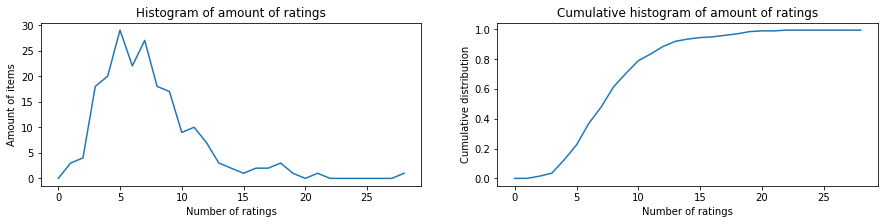

In [23]:
import matplotlib.pyplot as plt

item_nbr_ratings = actual_ratings.apply(lambda col: np.sum(~np.isnan(col)), axis=1)
item_max_nbr_ratings = item_nbr_ratings.max()
range_item_max_nbr_ratings = range(item_max_nbr_ratings+1)

plt.figure(figsize=(15,3))
plt.subplot(121)
nbr_ratings_items = []
for i in range_item_max_nbr_ratings:
    nbr_ratings_items.append(len(item_nbr_ratings[item_nbr_ratings == i]))
plt.plot(nbr_ratings_items)
plt.xlabel('Number of ratings')
plt.ylabel('Amount of items')
plt.title('Histogram of amount of ratings')

plt.subplot(122)
cum_nbr_ratings_items = []
for i in range(len(nbr_ratings_items)):
    cum_nbr_ratings_items.append(np.sum(nbr_ratings_items[:i]))
    
cum_nbr_ratings_items = np.array(cum_nbr_ratings_items)
plt.plot(cum_nbr_ratings_items/actual_ratings.shape[0])
plt.xlabel('Number of ratings')
plt.ylabel('Cumulative distribution')
plt.title('Cumulative histogram of amount of ratings');